# BayFlux Analysis of command line output
By Tyler W. H. Backman

In [1]:
%matplotlib inline

In [2]:
from pymc import gelman_rubin
import matplotlib.pyplot as plt
import matplotlib
import cobra
import os
import math
from cobra.flux_analysis import flux_variability_analysis
import bayflux
import pandas as pd
import numpy as np
import re
from scipy.stats import norm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import ntpath
from cobra.sampling import MCMCACHRSampler
sns.set(style="white")
print(cobra.__version__)
pd.set_option('display.max_rows', 1000)

0.18.1


In [3]:
matplotlib.rcParams['figure.figsize'] = (16,8)

In [4]:
# Specify config file
configFile = 'pyk5h.yaml'

In [5]:
# parse config file into variable configData
with open(configFile, 'r') as stream:
    try:
        configData = yaml.safe_load(stream)
    except yaml.YAMLError as exception:
        print(exception)

In [6]:
# get list of existing output files we could resume from
outputFolder = ntpath.dirname(configData['outputBaseName'])

files = os.listdir(outputFolder) 
matchingFiles = list(filter(lambda x: re.match('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy$', x), files))
fileNameIntegers = [int(re.sub('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy', r'\1', filename)) for filename in matchingFiles]

In [7]:
# for now, resume from the largest one only
resumeHere = max(fileNameIntegers)

# define function to generate an output filename from a number
def integerToFilename(outputBaseName, x, zfill=3):
    return outputBaseName + str(x).zfill(zfill) + '.npy'

In [8]:
sampleFilename = integerToFilename(configData['outputBaseName'], resumeHere)

In [9]:
# load samples
data = np.load(os.path.join(sampleFilename))

In [10]:
# compute from data shape the number of MPI chains
chains = int(data.shape[0] / configData['bayesianSamplesPerTask'])
print('found ' + str(chains) + ' markov chains!')

found 4 markov chains!


Now we convert this model to a bayflux ReactionNetwork, which inherets 'EnhancedReaction' objects from each cobra.Reaction, allowing us to add in atom transitions

In [11]:
cobrapymodel = cobra.io.read_sbml_model(configData['modelFile'])
model = bayflux.ReactionNetwork(cobrapymodel)
model

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


<ReactionNetwork iAF1260 at 0x7f4570370ac0>

In [14]:
# Import and apply exchange fluxes from file
model.readFluxConstraints(configData['fluxBoundsFile'])

# set max flux
limit = configData['maxFlux']
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

# run FBA to confirm model works
model.optimize()

<Solution 0.760 at 0x7f4567fdfc10>

In [15]:
mcmcachr = cobra.sampling.MCMCACHRSampler(model)

In [16]:
%%time
# start by warming up with samples ignoring probability to get center
# samplesToCollect = configData['centeringSamplesPerTask']
samplesToCollect = 100000
warmupSamples = mcmcachr.sample(samplesToCollect, fluxes=False, likelihood=False)
warmupSamples.shape

acceptance rate: 1.0
CPU times: user 19min 27s, sys: 1.5 s, total: 19min 29s
Wall time: 19min 29s


(100000, 1438)

In [17]:
# put the samples in a Pandas DF
realSamples = pd.DataFrame(data, columns=[v.name for v in model.variables])
del data

#### To plot marginals and trace we will just plot the last 90% of the first markov chain

In [18]:
endOfFirstChain = int(realSamples.shape[0] / chains)
endOfFirstChain

100000

In [19]:
startOfFirstChain = int(endOfFirstChain * 0.10)
startOfFirstChain

10000

In [20]:
firstChain = realSamples.iloc[startOfFirstChain:endOfFirstChain]
firstChain.shape

(90000, 1438)

In [21]:
netFirstChain = np.subtract(firstChain.iloc[:,0::2], firstChain.iloc[:,1::2])

/tmp/ipykernel_94360/559968163.py:1 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [22]:
# create a list of the reactions we want to plot fluxes for
allRxns = ['PGI','EDD','AKGDH', 'G6PDH2r']

# allRxns = [r.id for r in model.reactions][0:4]

<AxesSubplot:>

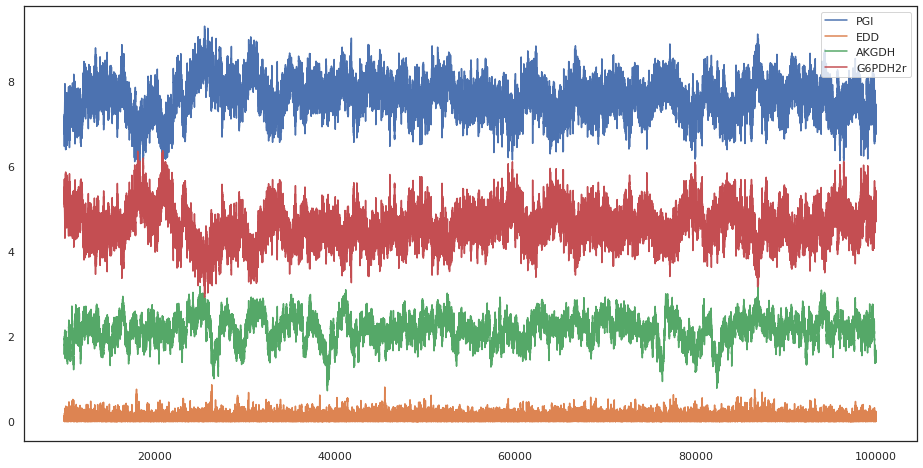

In [23]:
netFirstChain[allRxns].plot()

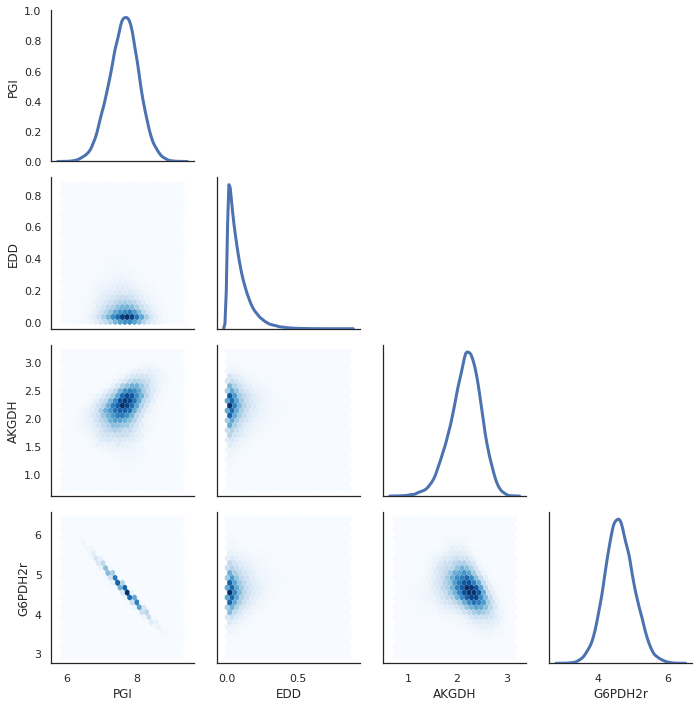

In [24]:
# plot sample distribution for samples
# start = int((realSamples.shape[0]/10))
# g = sns.PairGrid(realSamples[allRxns].iloc[start::realSampleThinning, :], diag_sharey=False)
g = sns.PairGrid(netFirstChain[allRxns], diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
g.map_diag(sns.kdeplot, lw=3, gridsize=100)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Plot marginal distributions for each reaction

Here we plot a marginal distribution for each reaction as a net flux, while excluding the first 10% of the samples, and by adding the forward and reverse fluxes to get net flux for reversible reactions.

In [25]:
# summarize the samples to be plotted

deleteStart = 0
netSamples = np.subtract(firstChain.iloc[deleteStart::1,0::2], firstChain.iloc[deleteStart::1,1::2])
netUniform = np.subtract(warmupSamples.iloc[deleteStart::1,0::2], warmupSamples.iloc[deleteStart::1,1::2])
display(netUniform.shape)
display(netSamples.shape)

/tmp/ipykernel_94360/1342583405.py:4 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
/tmp/ipykernel_94360/1342583405.py:5 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1

(100000, 719)

(90000, 719)

In [26]:
# remove reactions with no variance, e.g. they cannot carry flux or were fully constrained

rxnsWithVariance = netUniform.std(axis=0) > 0.001
netUniform = netUniform.loc[:,rxnsWithVariance]
netSamples = netSamples.loc[:,rxnsWithVariance]

In [27]:
netUniform.shape

(100000, 509)

In [28]:
warmupSampleThinning = math.ceil(warmupSamples.shape[0]/100000)
warmupSampleThinning
realSampleThinning = math.ceil(netSamples.shape[0]/100000)
realSampleThinning

1

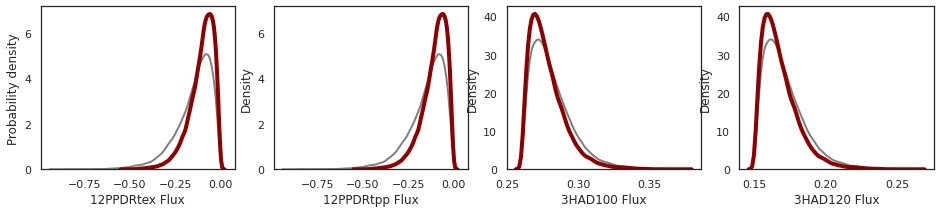

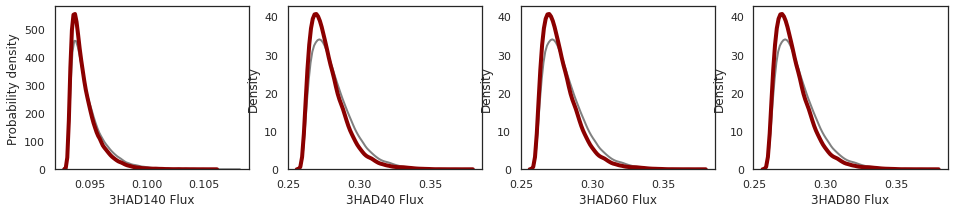

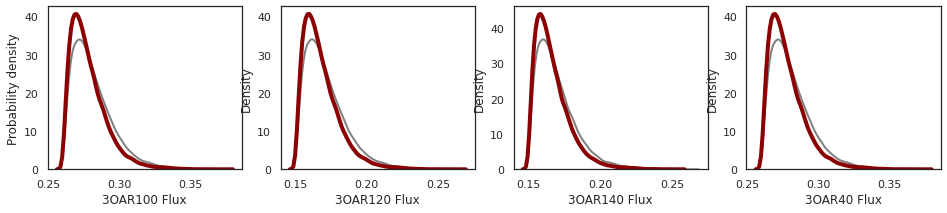

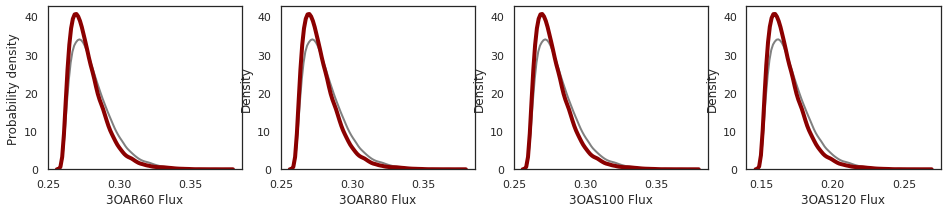

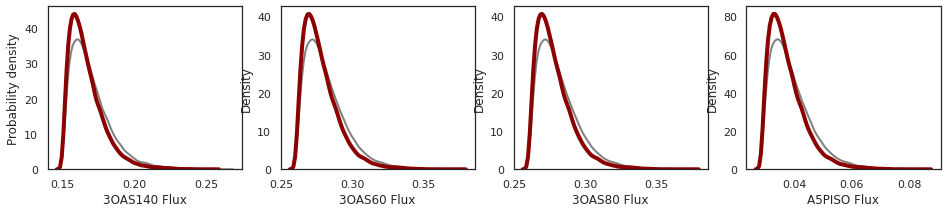

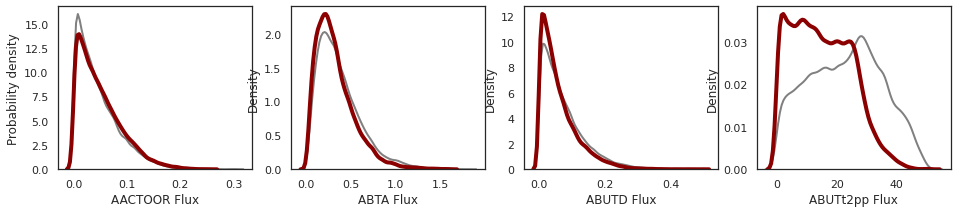

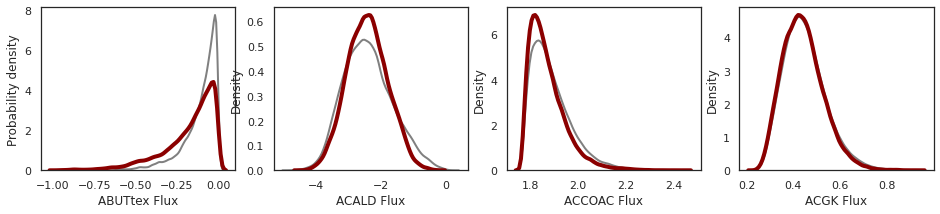

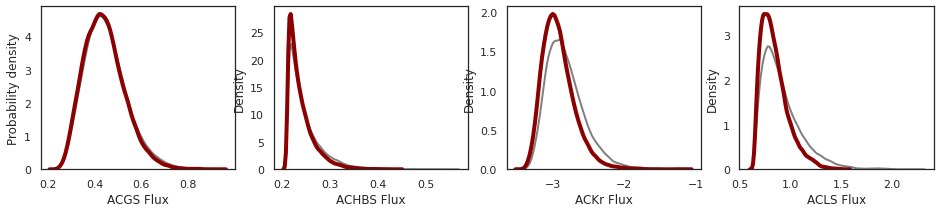

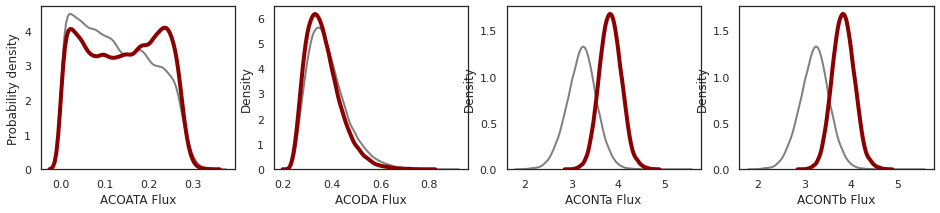

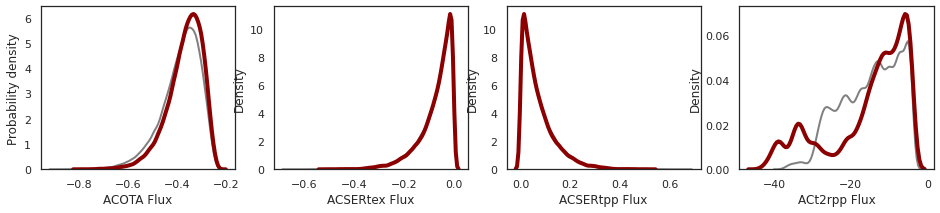

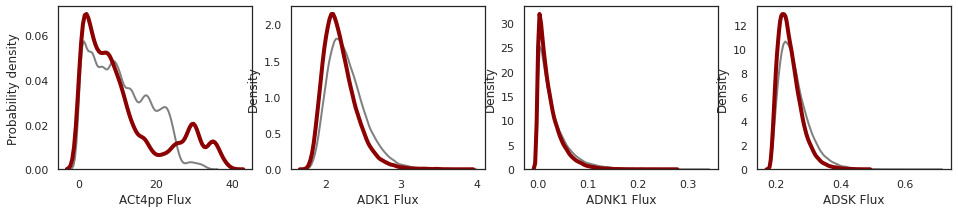

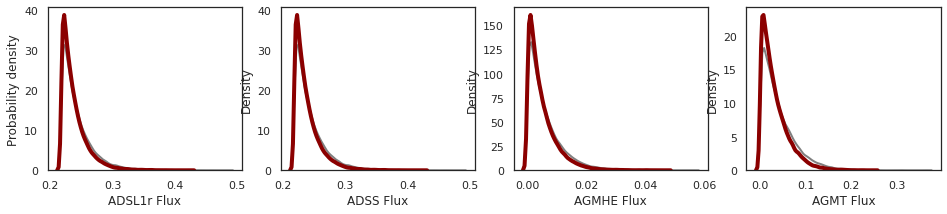

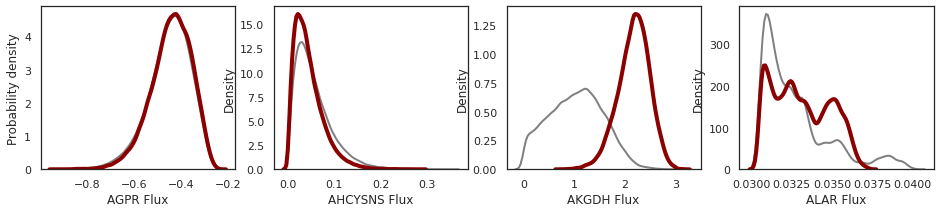

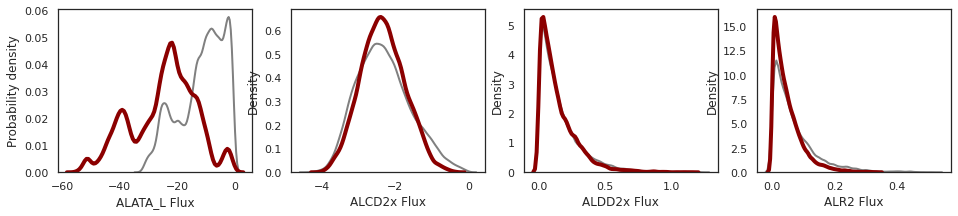

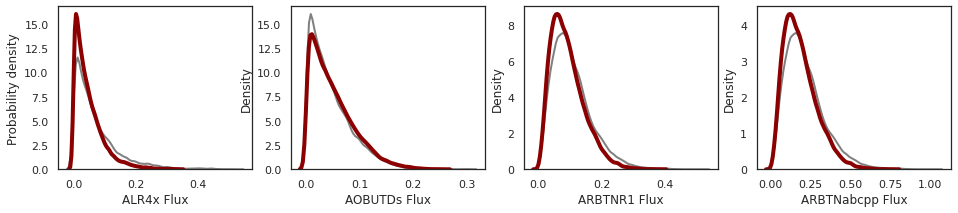

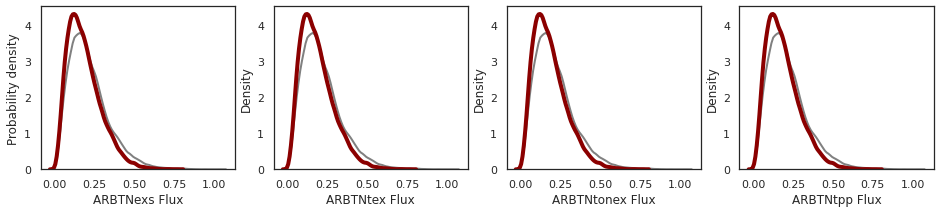

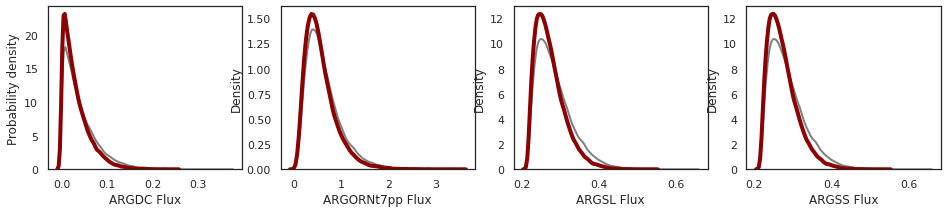

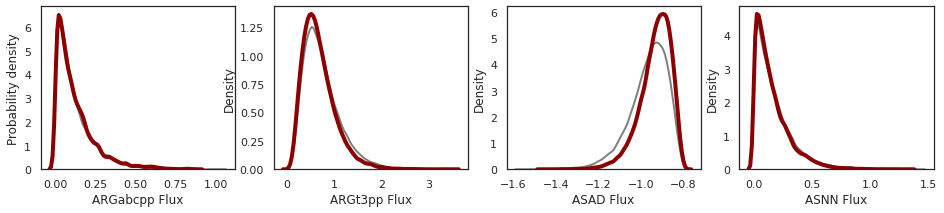

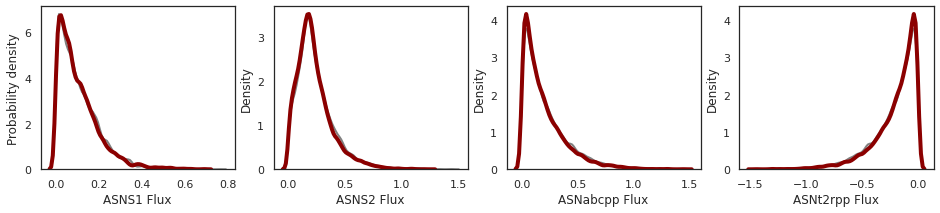

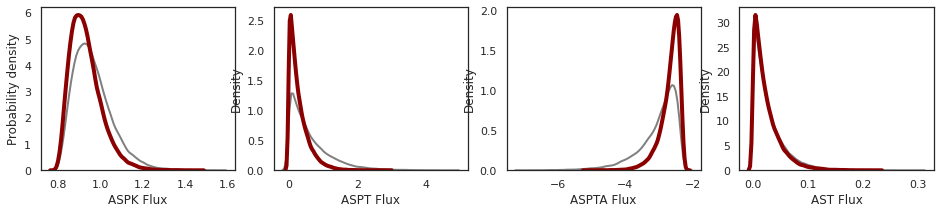

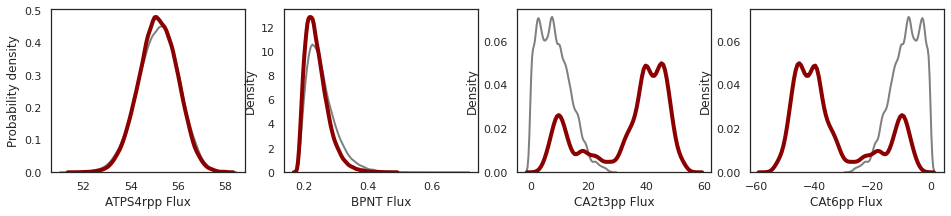

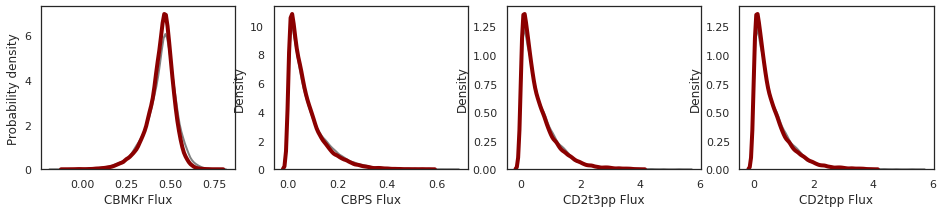

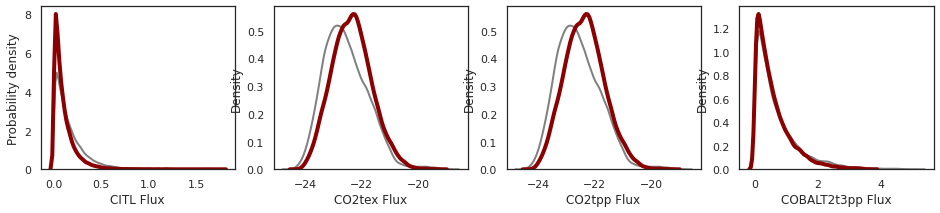

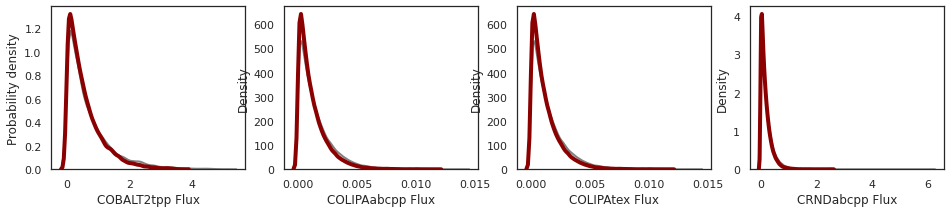

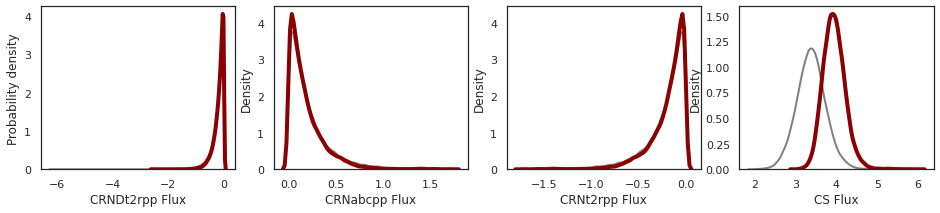

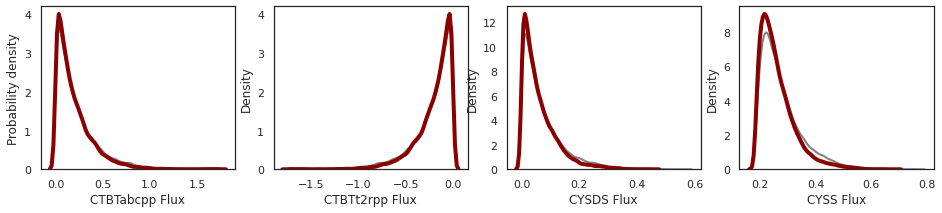

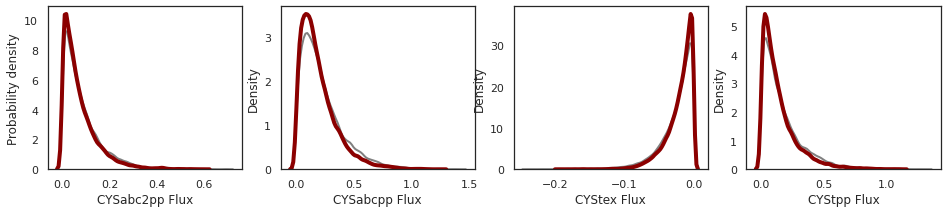

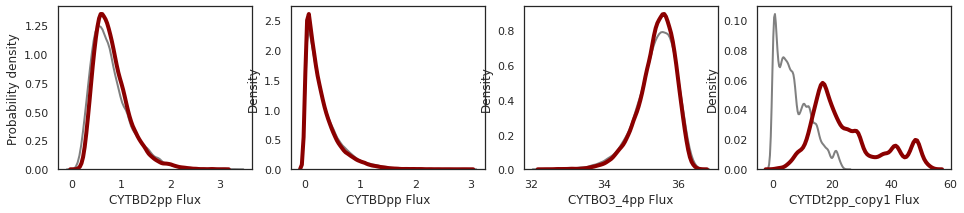

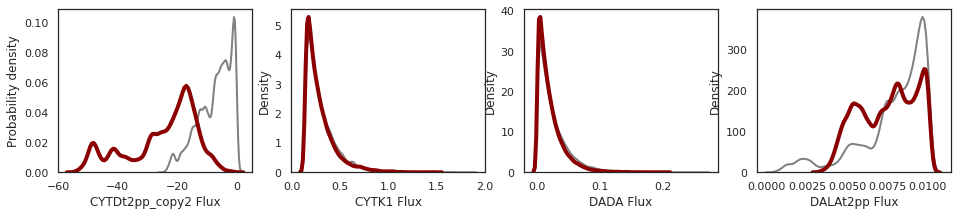

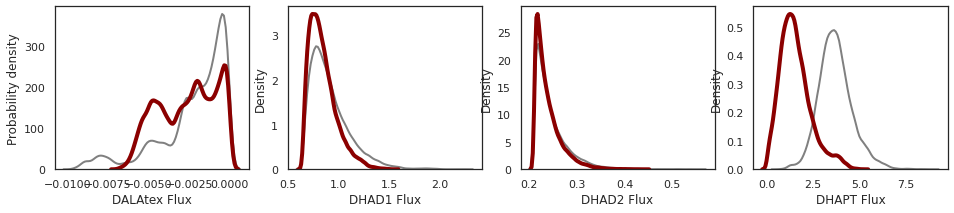

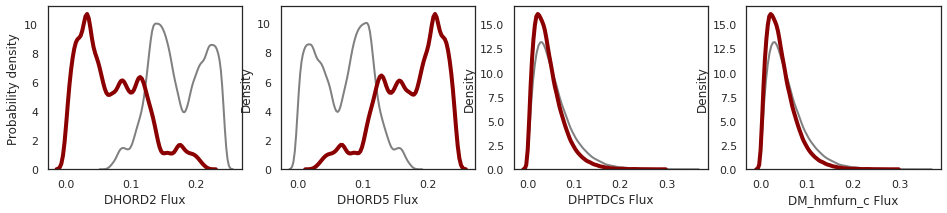

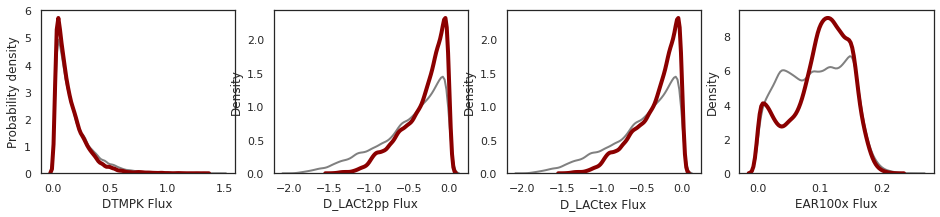

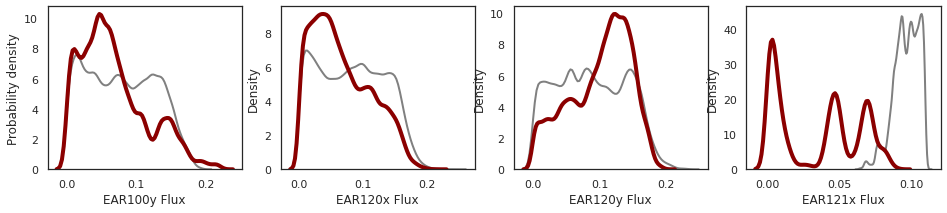

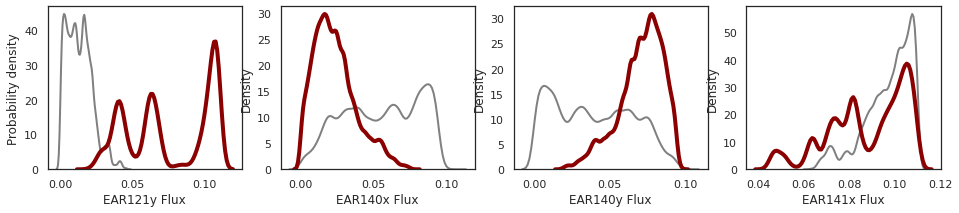

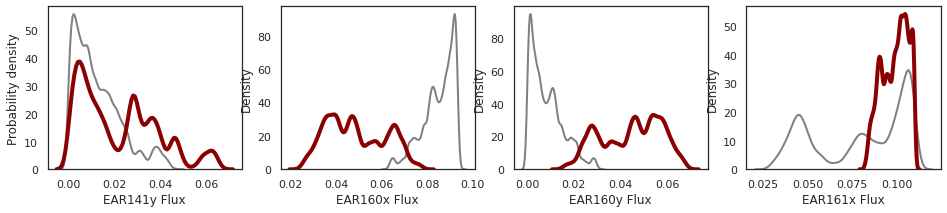

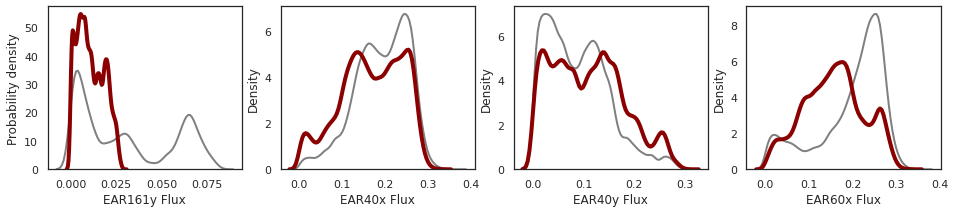

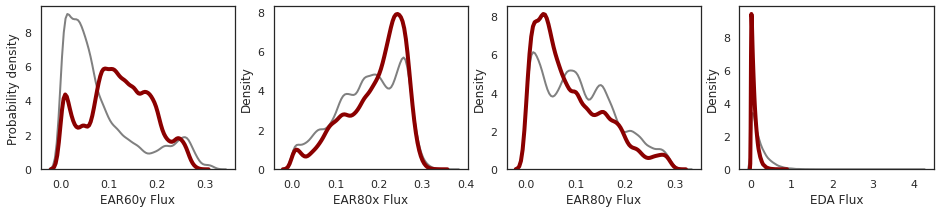

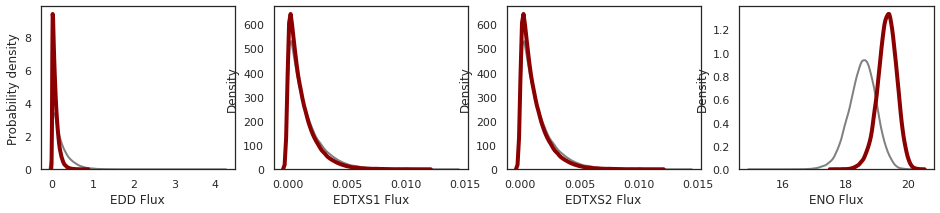

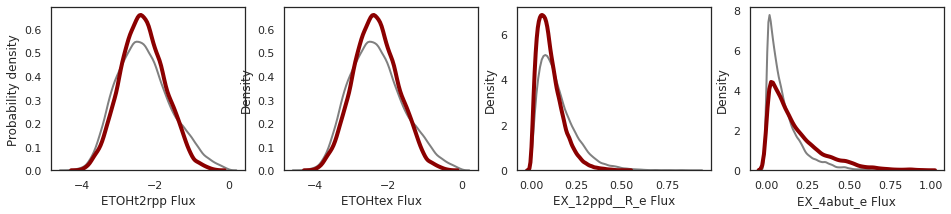

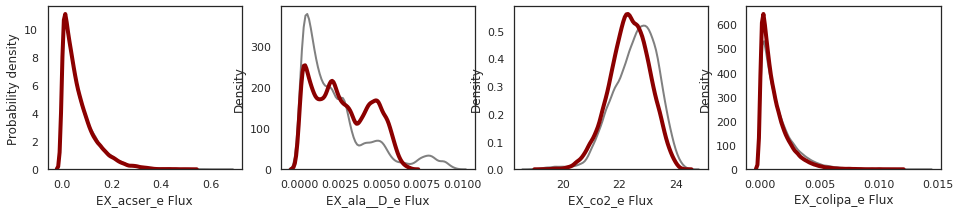

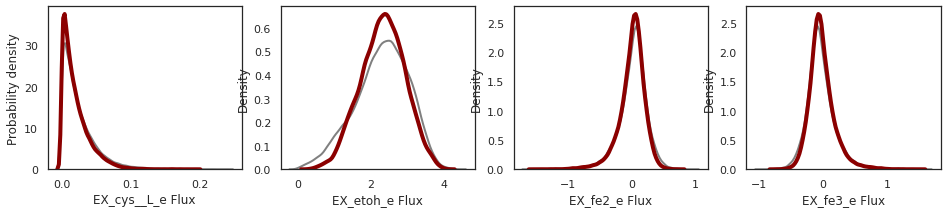

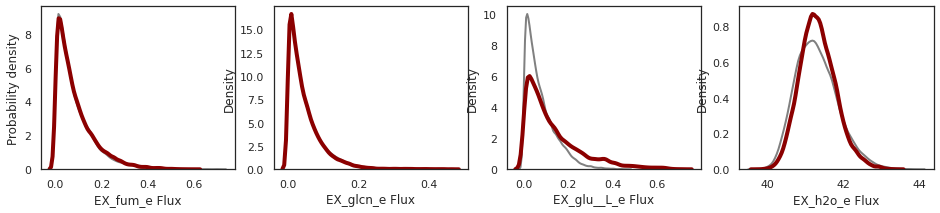

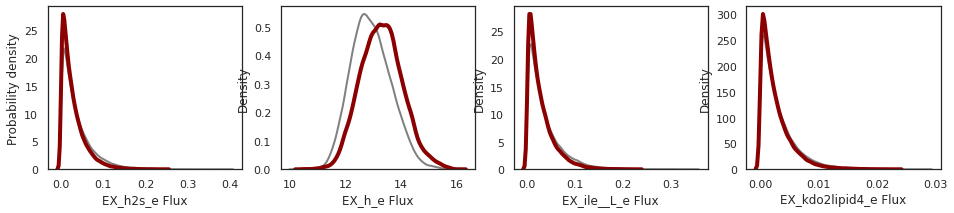

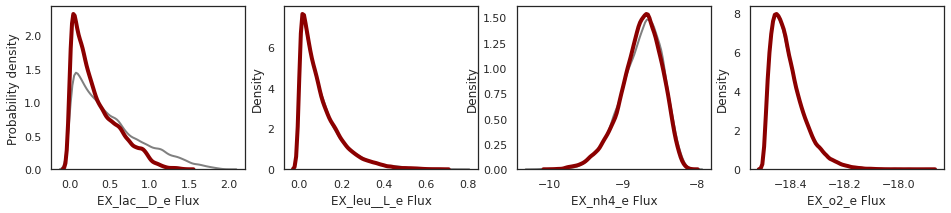

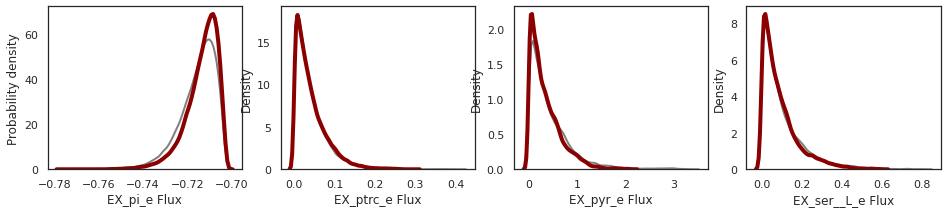

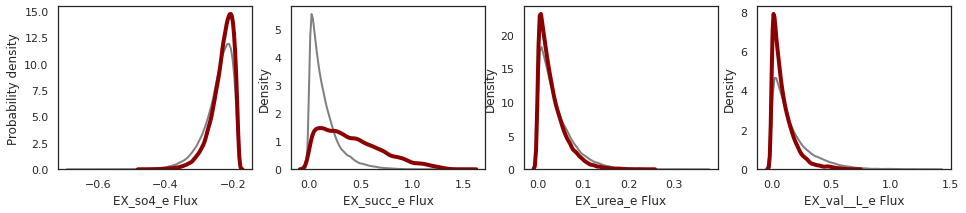

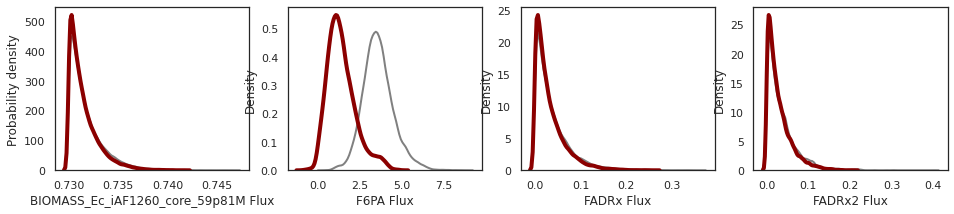

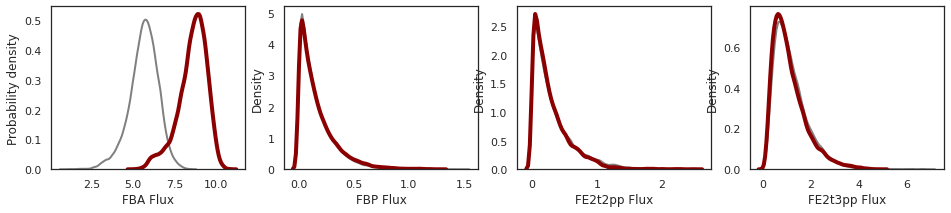

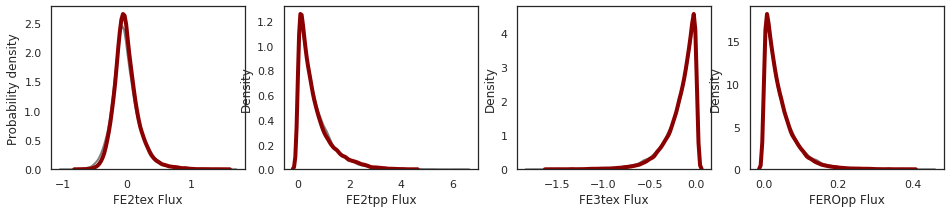

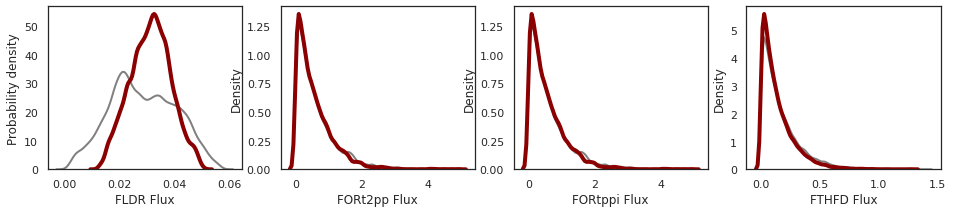

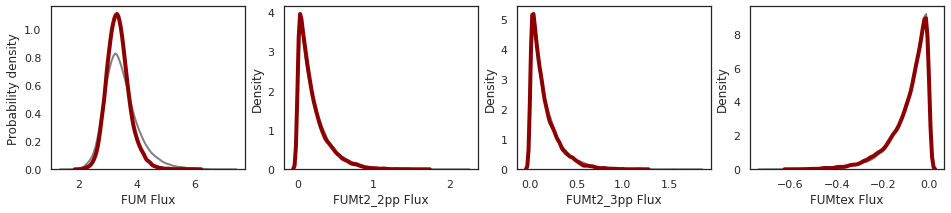

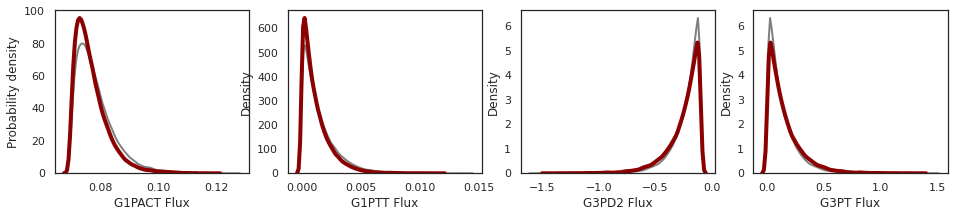

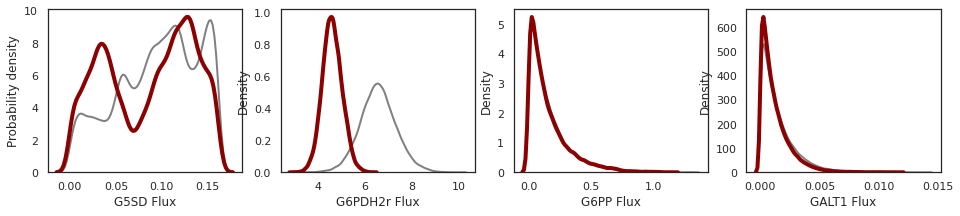

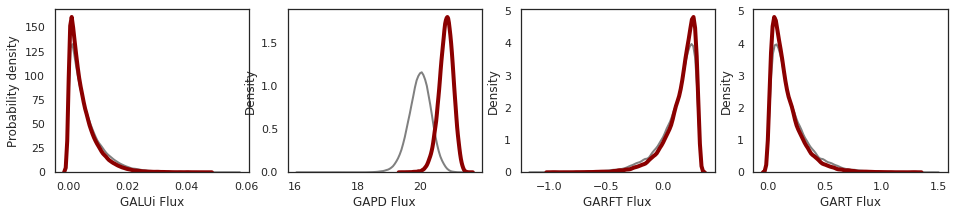

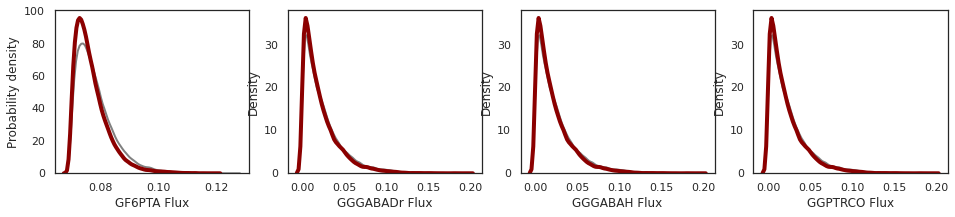

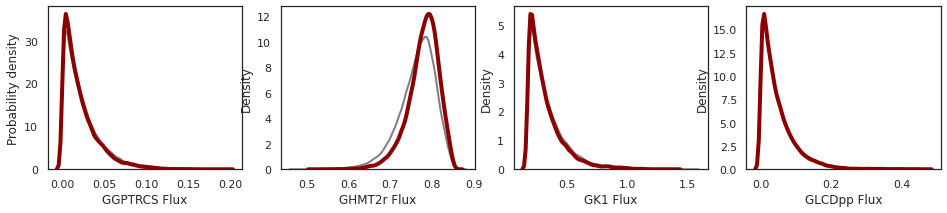

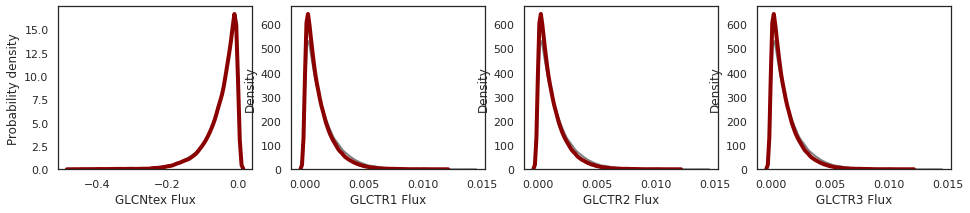

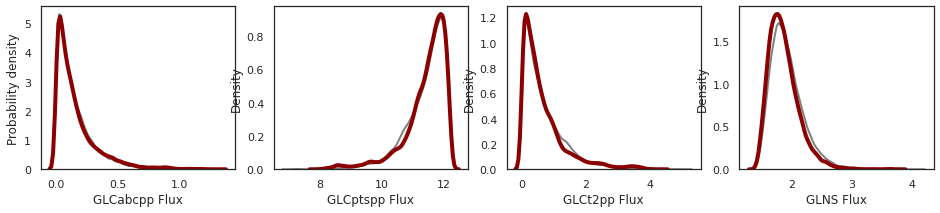

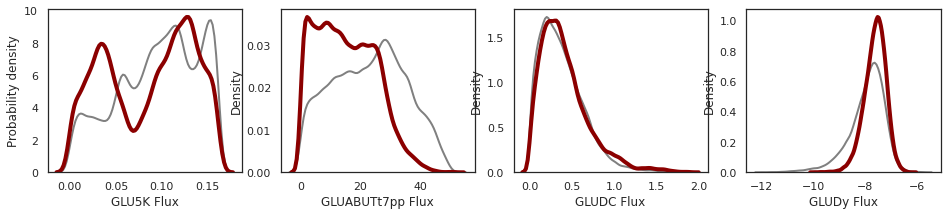

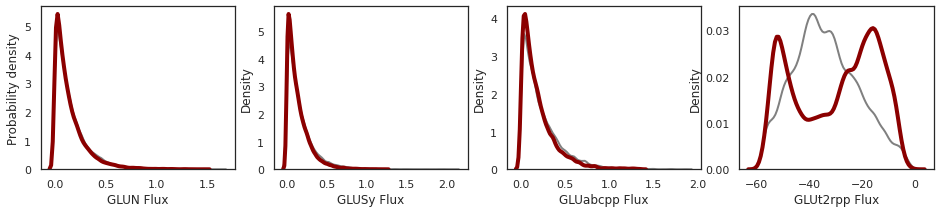

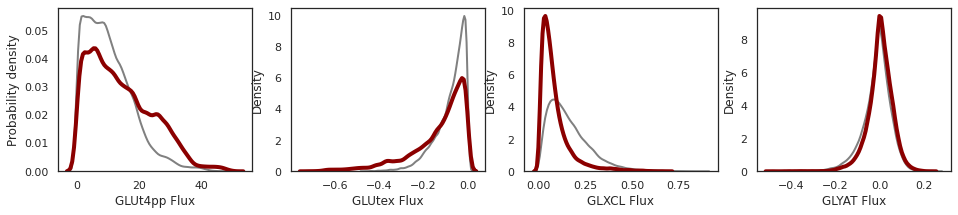

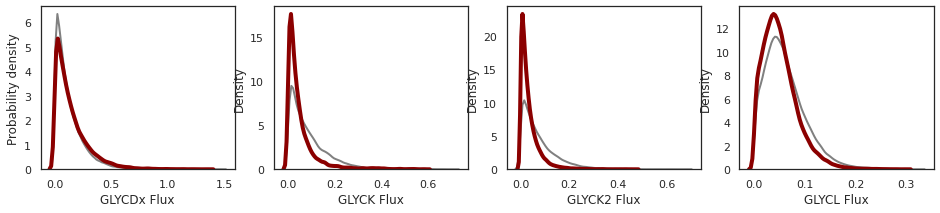

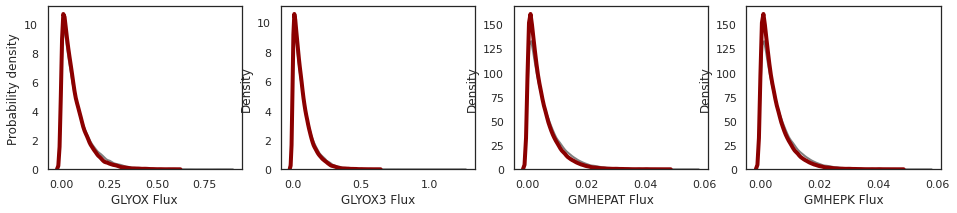

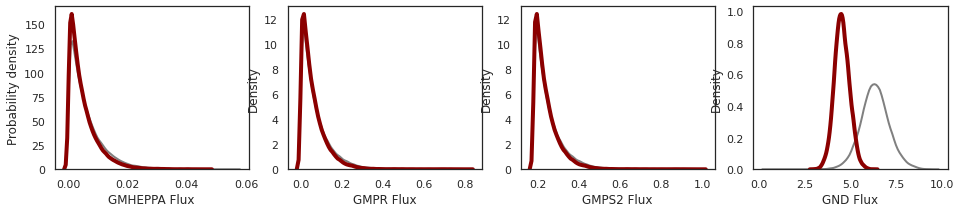

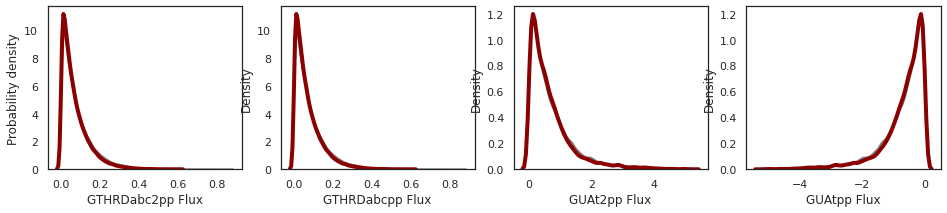

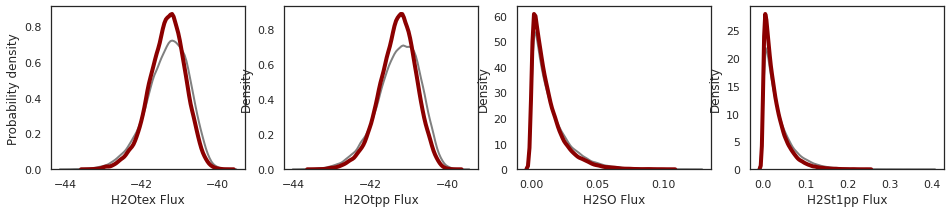

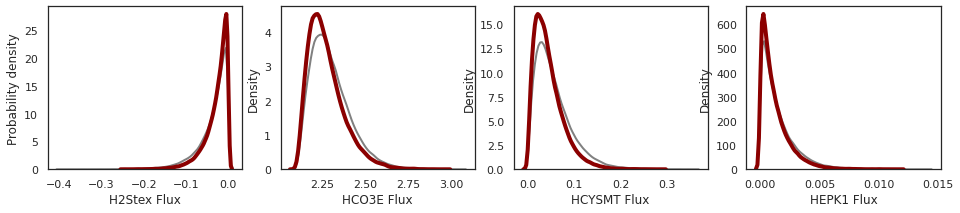

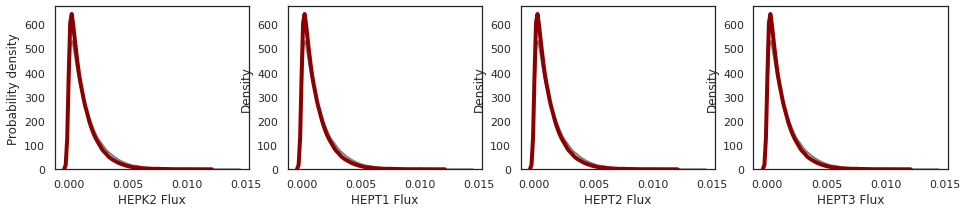

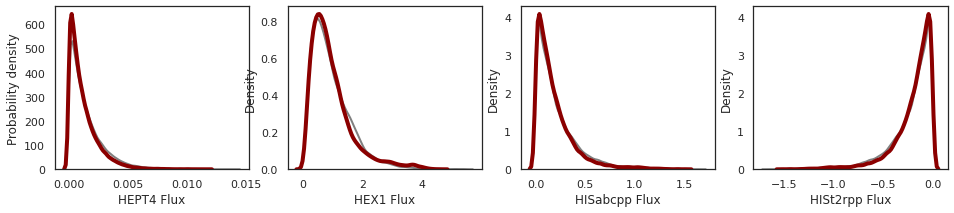

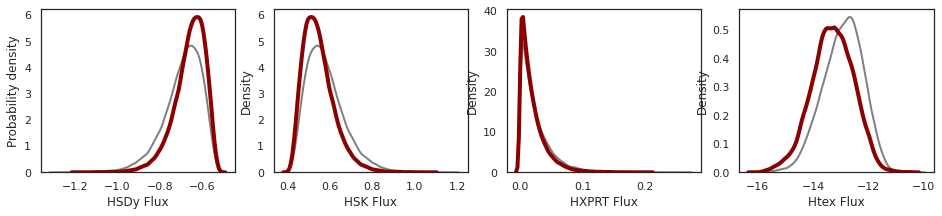

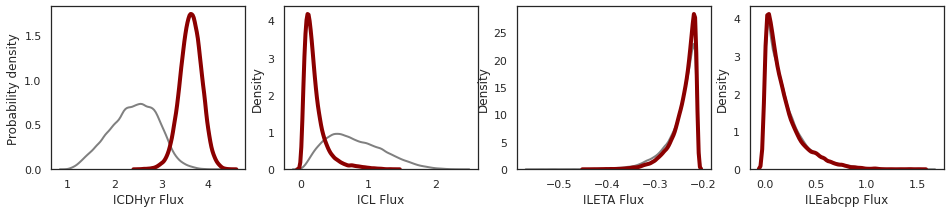

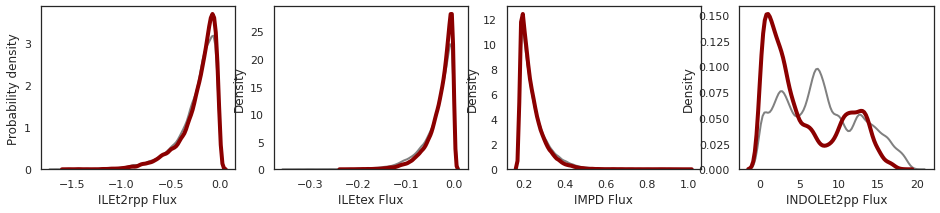

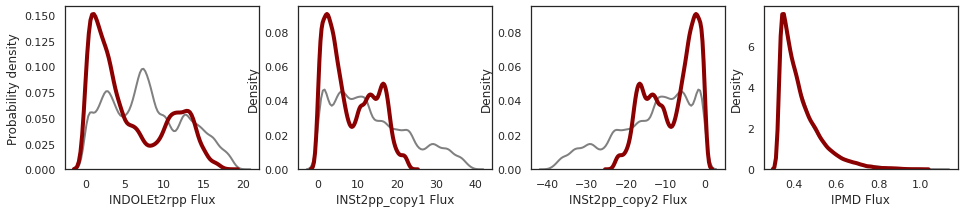

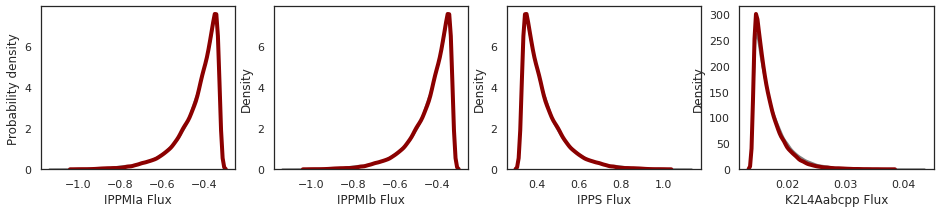

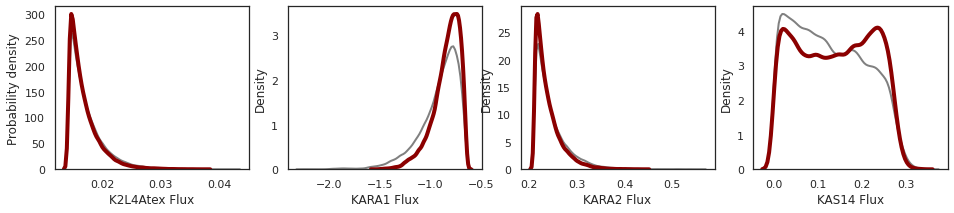

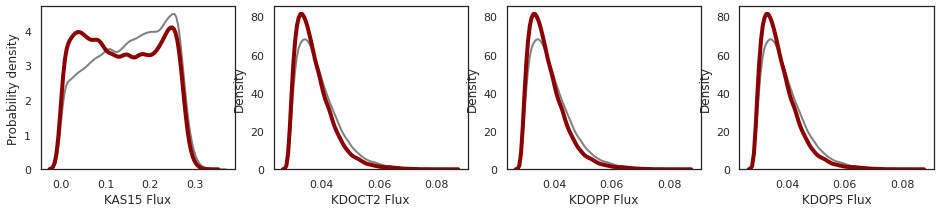

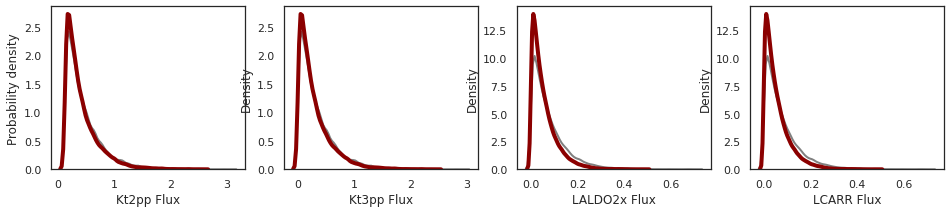

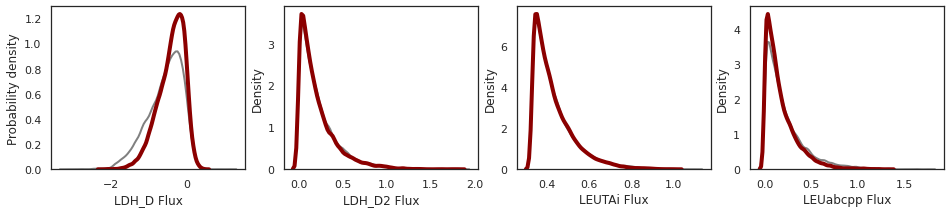

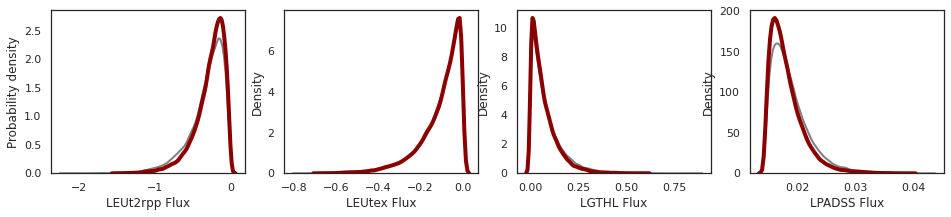

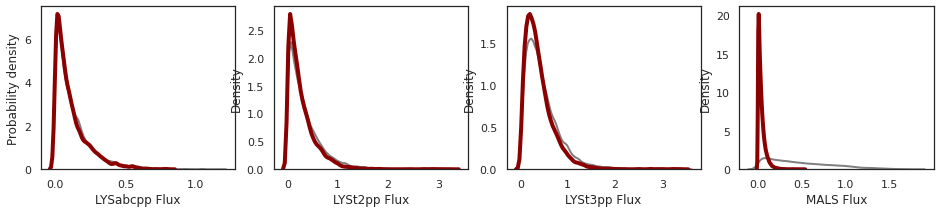

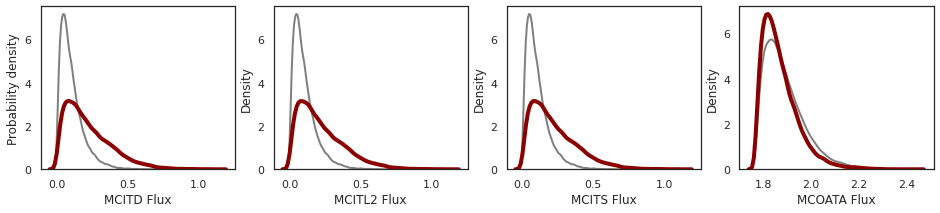

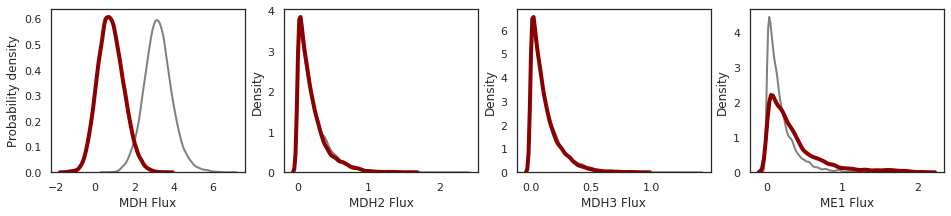

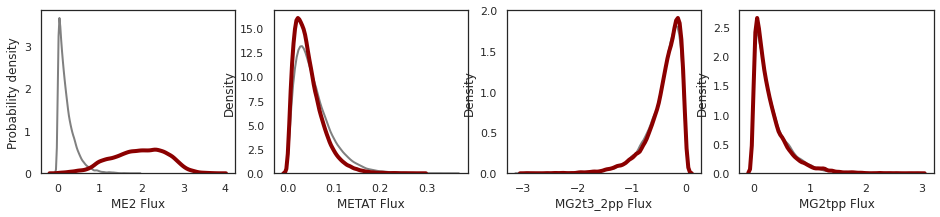

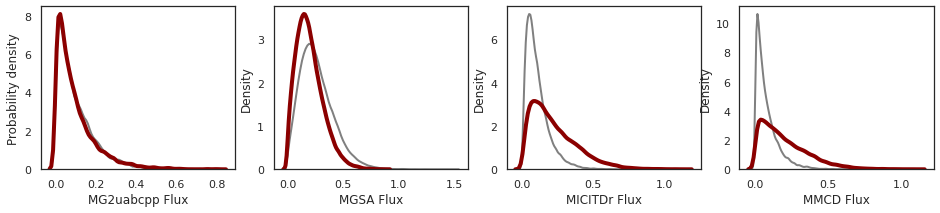

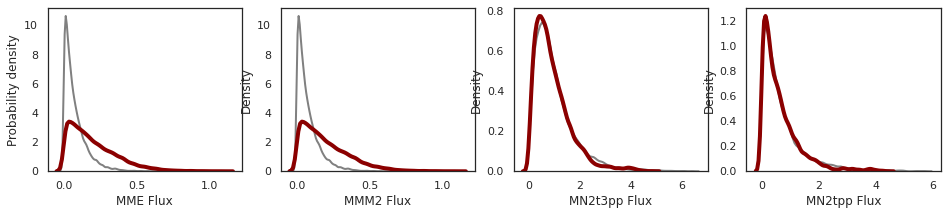

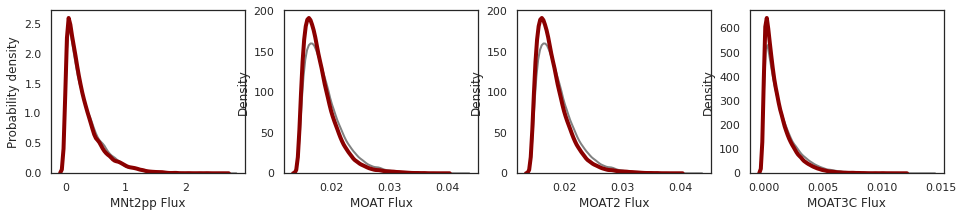

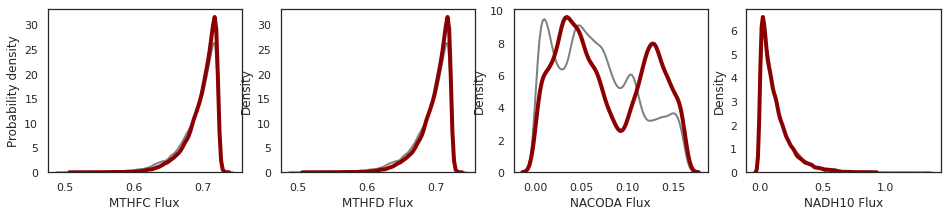

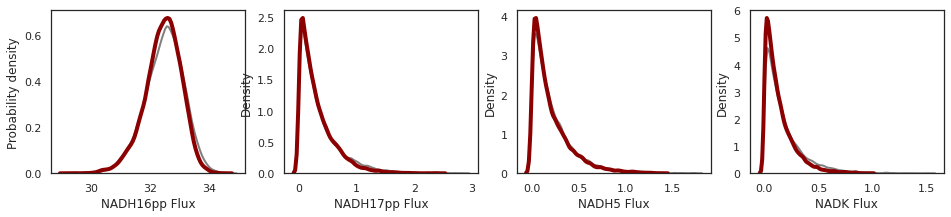

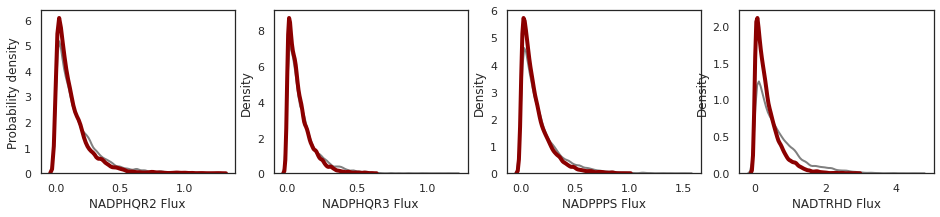

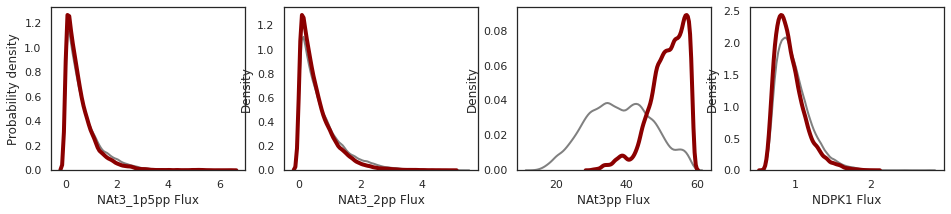

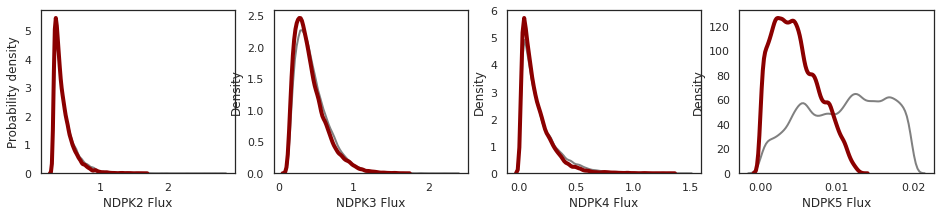

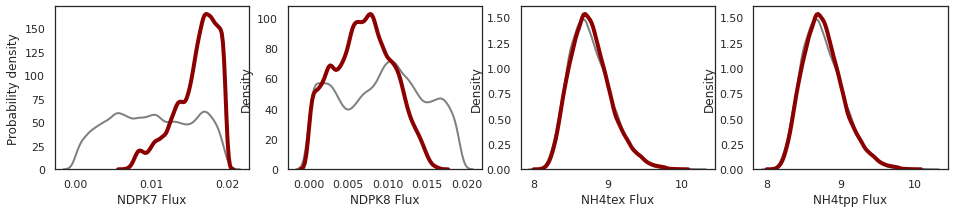

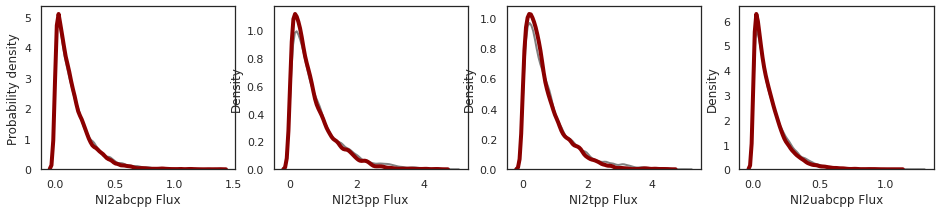

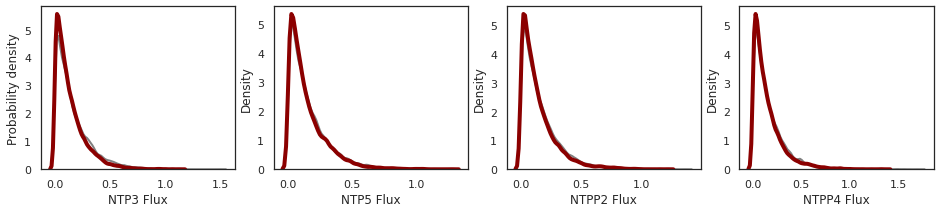

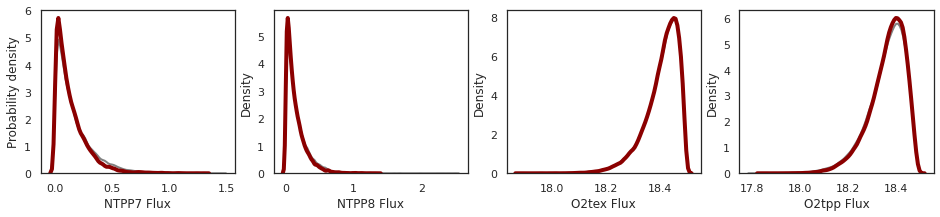

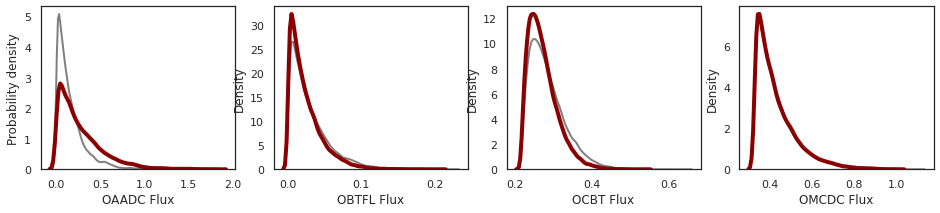

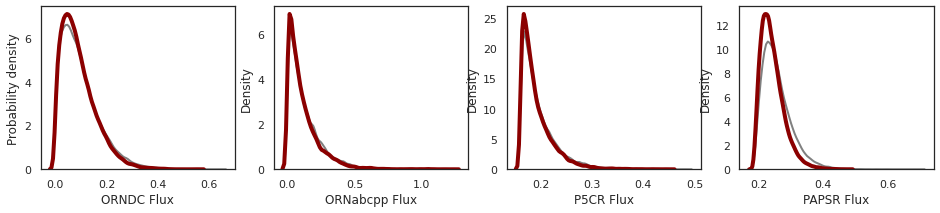

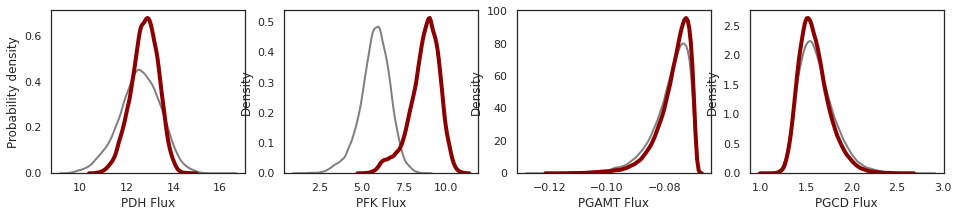

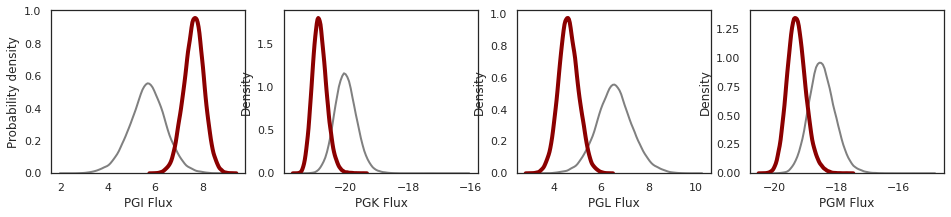

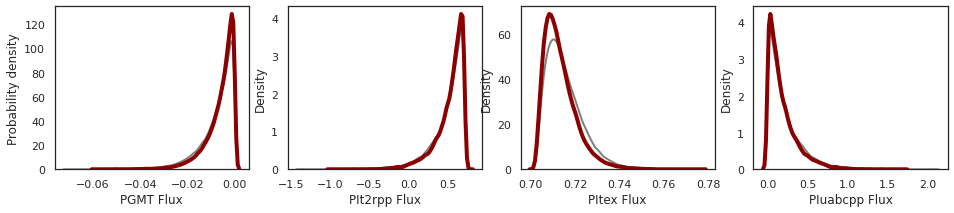

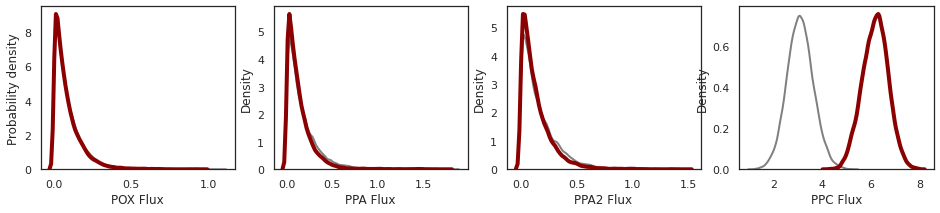

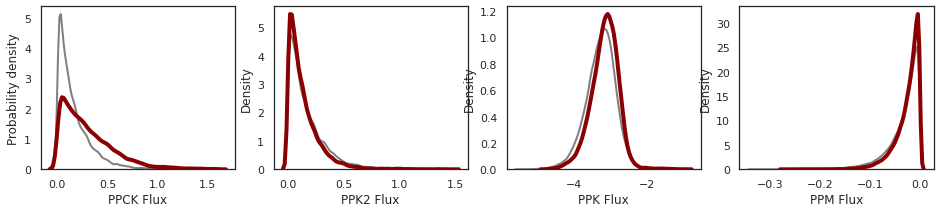

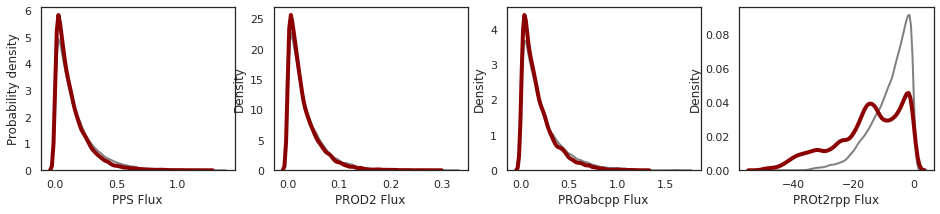

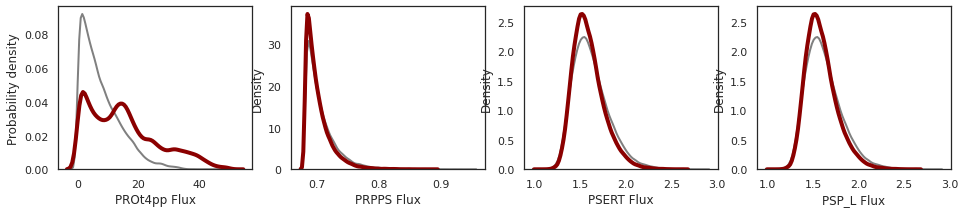

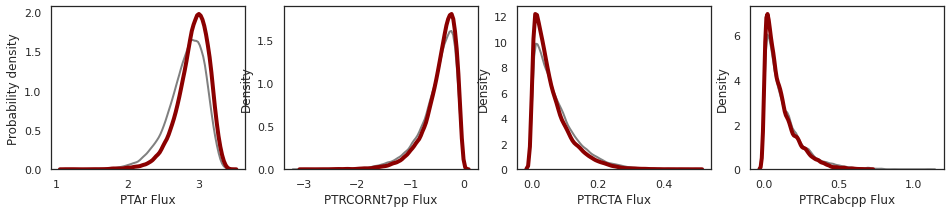

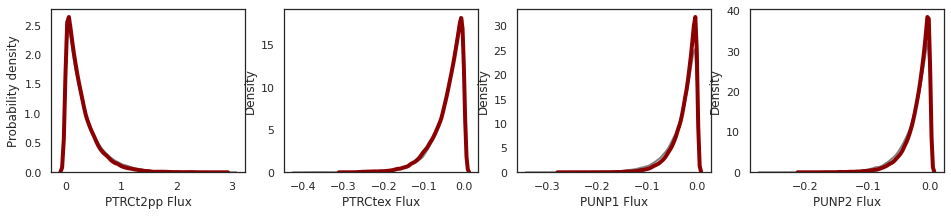

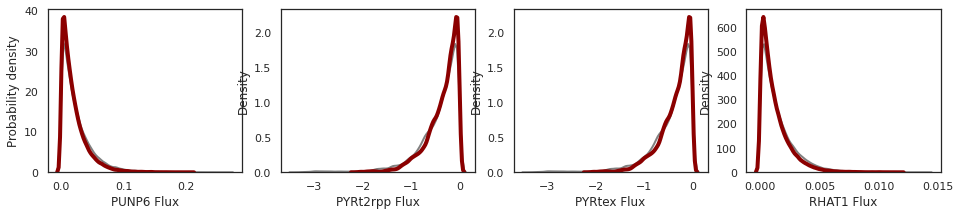

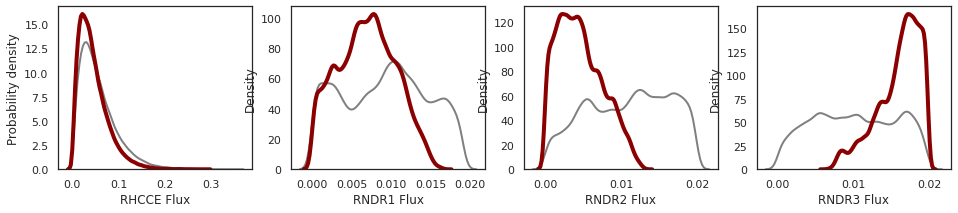

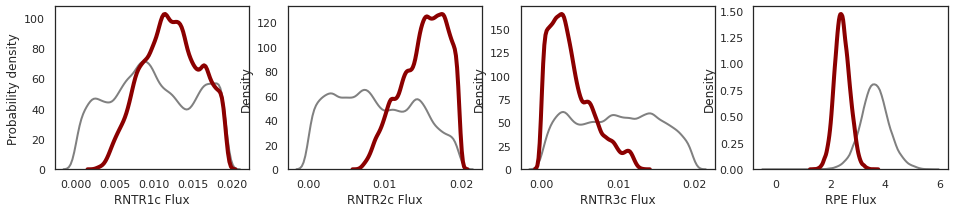

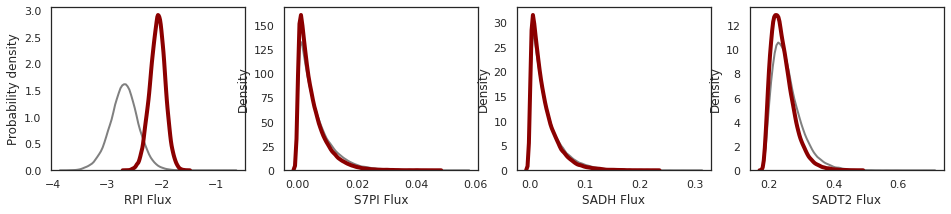

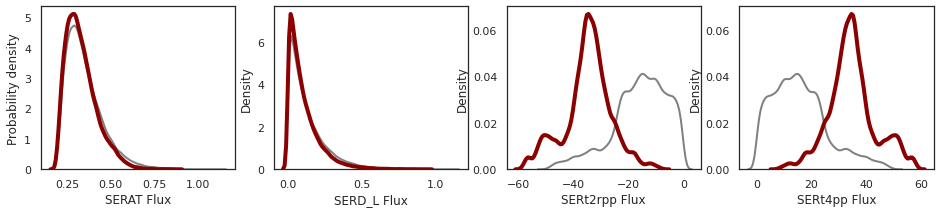

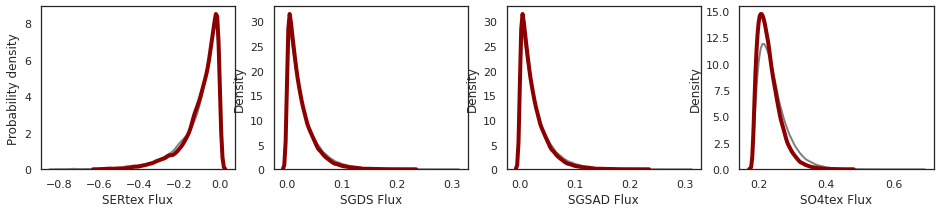

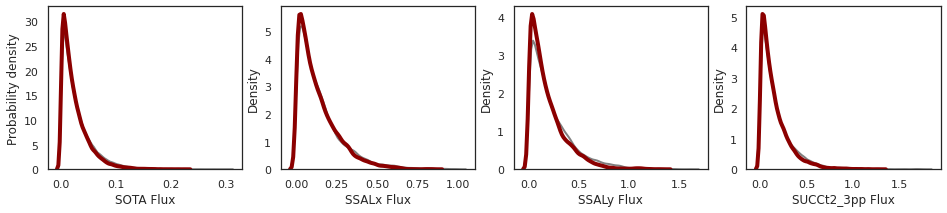

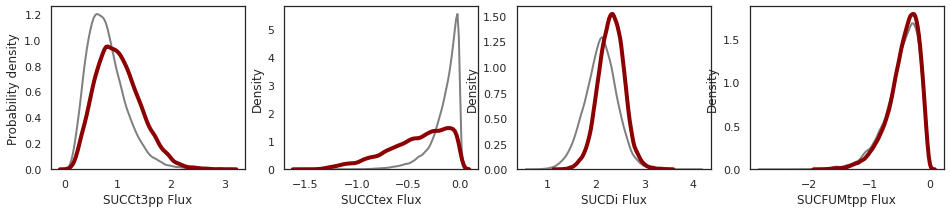

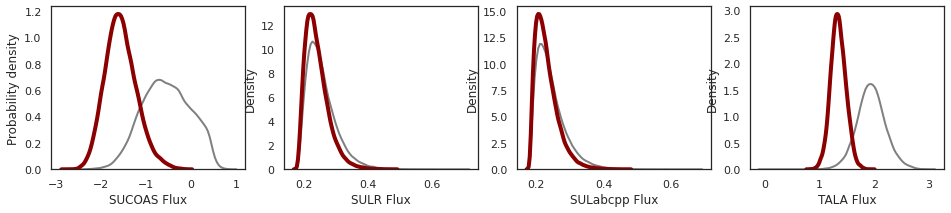

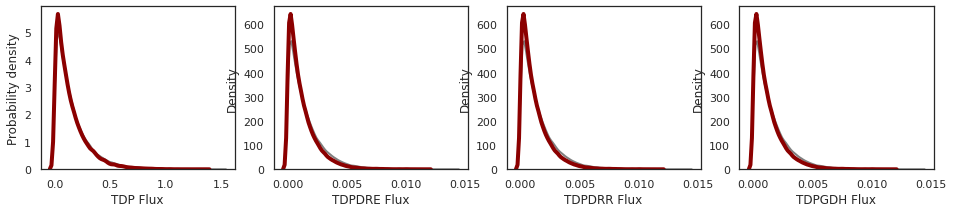

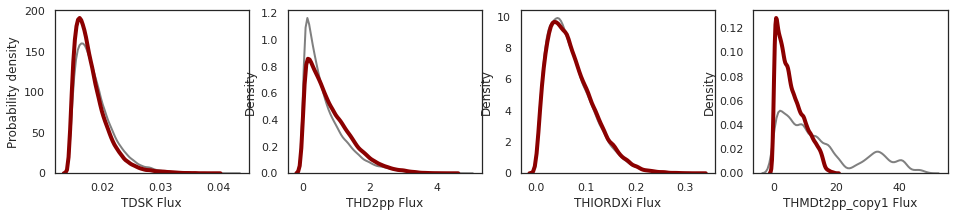

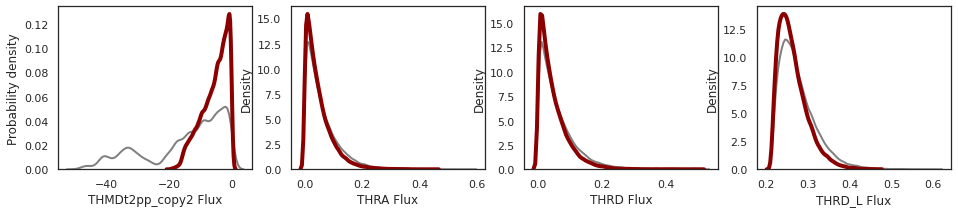

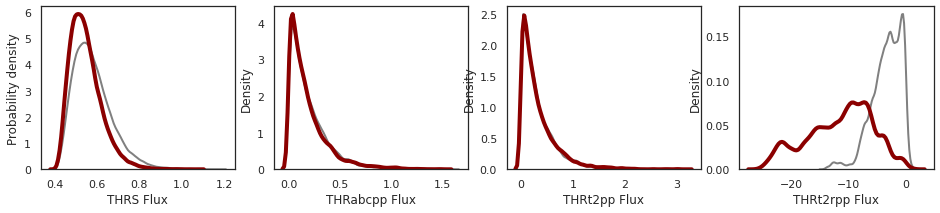

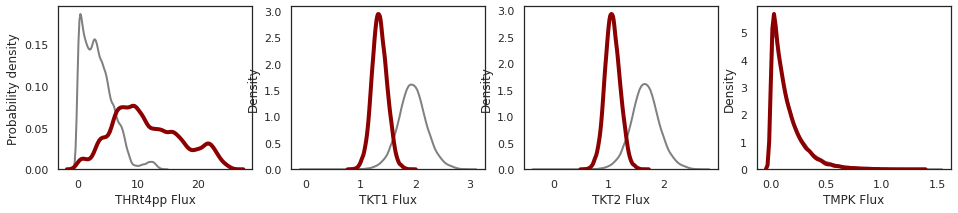

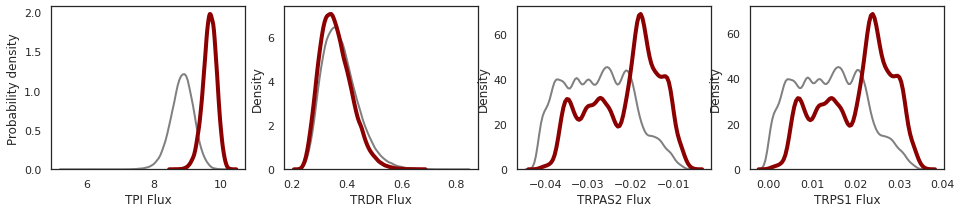

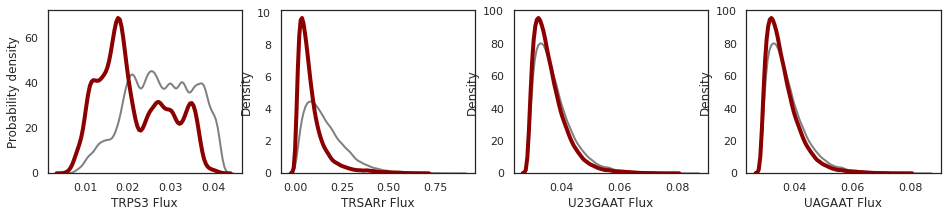

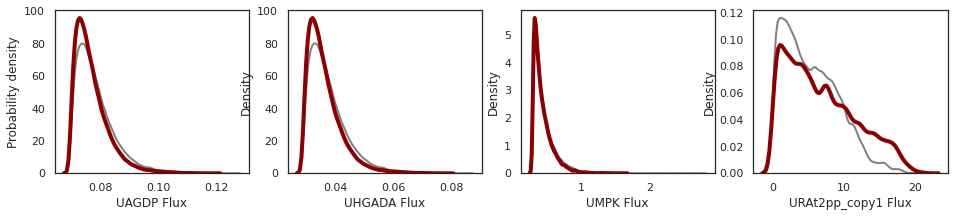

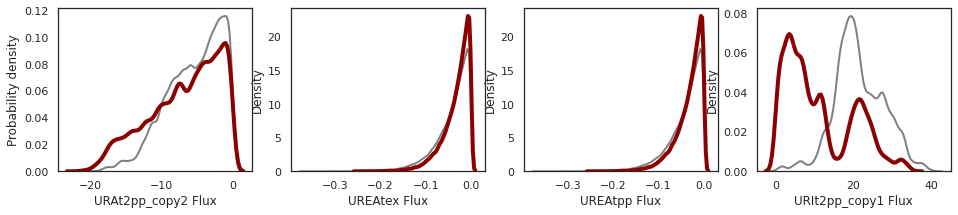

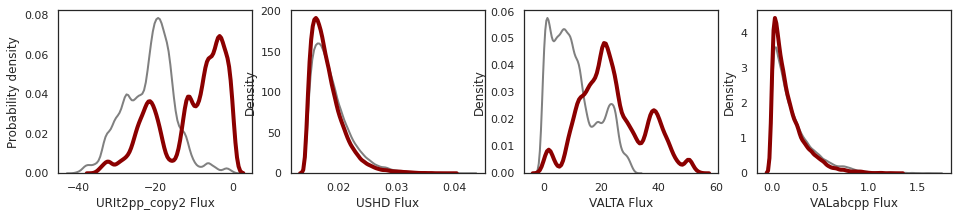

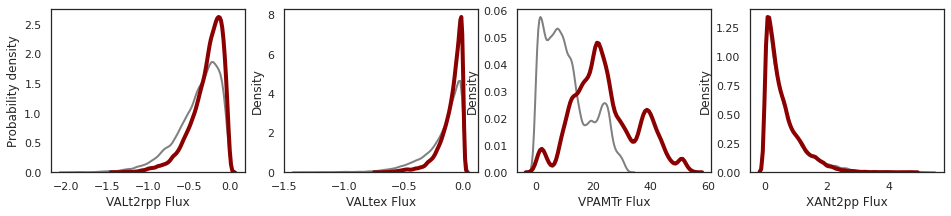

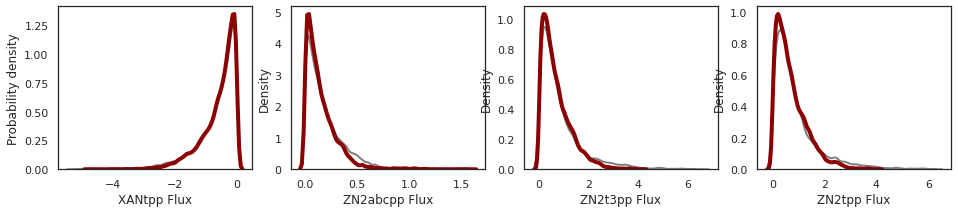

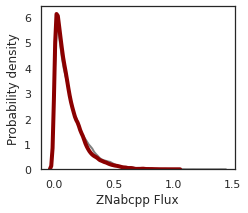

In [29]:
# plot marginals

cols = 4
rows = math.ceil(netUniform.shape[1]/cols)

matplotlib.rcParams['figure.figsize'] = (16,3)
for j in range(0, rows):
    for k in range(0, cols):
        i = (j*cols) + k
        if i > (netUniform.shape[1] - 1):
            break
        # try:
        plt.subplot(1, cols, k + 1)
        sns.kdeplot(netUniform.iloc[0::warmupSampleThinning,i], lw=2, gridsize=100, color="grey", label="Uniform")
        sns.kdeplot(netSamples.iloc[0::realSampleThinning,i], lw=4, gridsize=100, color="darkred")
        # except:
            # continue

        plt.xlabel(netUniform.columns[i] + " Flux")
        if k == 0:
            plt.ylabel("Probability density")
    plt.show()

### Analyze sampler convergence with Gelman–Rubin diagnostic

Each chain sampling from the posterior effectively starts at a different random location from a uniform sample of the flux space because of the warmupSamples, which end at a different spot depending on the random seed. Values close to 1.0 (for example 1.1 or less) typically indicate convergence.

In [30]:
samplesPerChain = configData['bayesianSamplesPerTask']

In [31]:
# compute stat with net fluxes only
# comment these out if we want to analyze each direction independently
numpysamples = np.array(realSamples)
data = np.subtract(numpysamples[:,0::2], numpysamples[:,1::2])
data.shape

(400000, 719)

In [32]:
# compute Gelman–Rubin diagnostic

# define a number of 'burn in' samples which will be discarded, and not used to compute
# the GR diagnostic
burnin = int(samplesPerChain/4) # discard the first quarter samples

# reshape data into a 3D array where each 1st dimension is a chain as used by pymc
samples = data.shape[0]
# chains = len(seeds)
data3D = np.reshape(data, newshape=(chains, samplesPerChain,-1), order='C')
thin = int(math.ceil(samplesPerChain/10))

# iteratively analyze convergence with stepsize thin
# using the gelman_rubin function from pymc
grStats = np.zeros(shape=(int((samplesPerChain - burnin)/thin), data3D.shape[2]), dtype=np.float64, order='C')
for point in range(1, int((samplesPerChain - burnin)/thin) + 1):
    thisPoint = int(point * thin) + burnin
    subset = np.take(data3D, range(burnin + 1, thisPoint), 1)
    print(subset.shape)
    grStats[point - 1] = gelman_rubin(subset)

(4, 9999, 719)


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/pymc/diagnostics.py:625 RuntimeWarning: invalid value encountered in double_scalars


(4, 19999, 719)
(4, 29999, 719)
(4, 39999, 719)
(4, 49999, 719)
(4, 59999, 719)
(4, 69999, 719)


<AxesSubplot:>

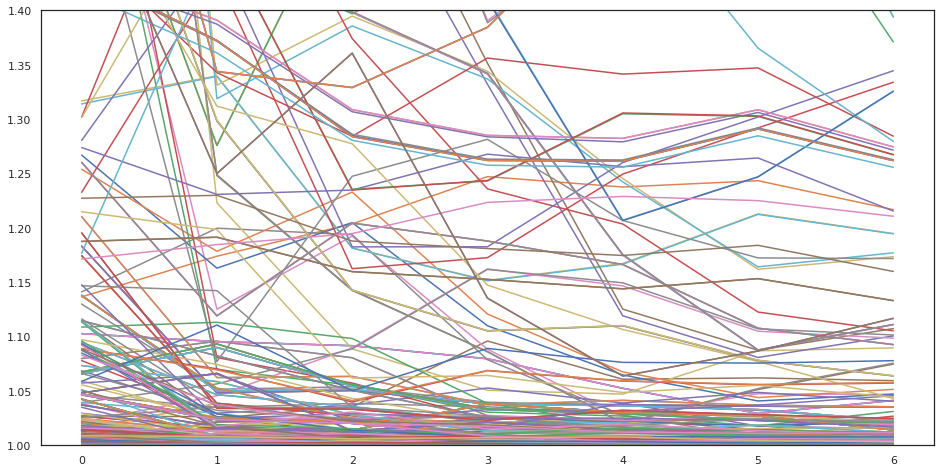

In [33]:
# plot the Gelman–Rubin diagnostic over the course of the simulation

matplotlib.rcParams['figure.figsize'] = (16,8)
# pd.DataFrame(grStats[100:,:]).plot(legend=False, ylim=(1,10))
pd.DataFrame(grStats).plot(legend=False, ylim=(1,1.4))

In [34]:
# print out final convergence by reaction name
# we drop all NAs, as they are all reverse directions for non reversible reactions
GRbyVariable = pd.DataFrame(grStats[grStats.shape[0] - 1], index=[v.name for v in model.variables][0::2], columns=['GR']).dropna()
GRbyVariable[rxnsWithVariance].sort_values(by='GR')

/tmp/ipykernel_94360/3340616574.py:4 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR
FADRx2                          1.000034
MDH2                            1.000041
H2St1pp                         1.000085
EX_h2s_e                        1.000085
H2Stex                          1.000085
ORNabcpp                        1.000095
MG2tpp                          1.000097
ARGORNt7pp                      1.000105
CD2t3pp                         1.000113
CD2tpp                          1.000113
PTRCt2pp                        1.000121
PTRCORNt7pp                     1.000125
GLYOX3                          1.000131
ILEabcpp                        1.000145
NTP5                            1.000148
ASNabcpp                        1.000151
ASNt2rpp                        1.000151
SSALx                           1.000154
P5CR                            1.000160
ILEt2rpp                        1.000161
PROD2                           1.000167
ACHBS                           1.000168
DHAD2                           1.000168
KARA2                           1.000168
ILETA                           1.000168
EX_ile__L_e                     1.000187
ILEtex                          1.000187
LGTHL                           1.000207
GLYOX                           1.000207
NI2uabcpp                       1.000235
XANtpp                          1.000240
XANt2pp                         1.000240
CYSDS                           1.000258
PUNP6                           1.000261
PUNP2                           1.000261
HXPRT                           1.000261
DADA                            1.000261
ADSS                            1.000266
ADSL1r                          1.000266
NADPHQR2                        1.000268
ARGt3pp                         1.000276
PRPPS                           1.000286
ZNabcpp                         1.000292
GMPR                            1.000305
CRNDabcpp                       1.000308
CRNDt2rpp                       1.000308
GMPS2                           1.000309
IMPD                            1.000309
ARBTNtonex                      1.000312
ARBTNexs                        1.000312
ARBTNabcpp                      1.000312
ARBTNtex                        1.000312
ARBTNtpp                        1.000312
ARBTNR1                         1.000312
MG2t3_2pp                       1.000313
THRA                            1.000316
GTHRDabcpp                      1.000319
GTHRDabc2pp                     1.000319
CBMKr                           1.000360
CYTBDpp                         1.000388
ALDD2x                          1.000420
PUNP1                           1.000424
PPM                             1.000424
ADNK1                           1.000424
H2SO                            1.000439
NTP3                            1.000454
SULabcpp                        1.000466
EX_so4_e                        1.000466
SO4tex                          1.000466
CYSS                            1.000471
MNt2pp                          1.000545
CYStpp                          1.000559
PPA                             1.000565
GGPTRCO                         1.000582
GGGABAH                         1.000582
GGPTRCS                         1.000582
GGGABADr                        1.000582
THRD                            1.000602
GLUSy                           1.000605
FEROpp                          1.000607
FE3tex                          1.000607
ADSK                            1.000641
PAPSR                           1.000641
SADT2                           1.000641
BPNT                            1.000641
SULR                            1.000641
METAT                           1.000644
DHPTDCs                         1.000644
DM_hmfurn_c                     1.000644
RHCCE                           1.000644
AHCYSNS                         1.000644
HCYSMT                          1.000644
PTRCabcpp                       1.000656
THRD_L                          1.000657
CYTK1                           1.000676
NDPK2                           1.000687
THRS                            1.000701
HSK                 

In [35]:
GRbyVariable.shape

(713, 1)

In [36]:
(GRbyVariable[rxnsWithVariance] < 1.10).sum()

/tmp/ipykernel_94360/3883560918.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR    424
dtype: int64

In [37]:
(GRbyVariable[rxnsWithVariance] > 1.10).sum()

/tmp/ipykernel_94360/1197693162.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR    85
dtype: int64